<a href="https://colab.research.google.com/github/wilkeraziz/emnlp-main-findings/blob/main/DP-shared-coefficients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up numpyro

In [1]:
!pip install numpyro funsor

# Data

I'm using the counts Ryan shared:

In [2]:
!git clone https://github.com/ryancotterell/emnlp2020-analysis.git

fatal: destination path 'emnlp2020-analysis' already exists and is not an empty directory.


In [3]:
def read(fname):
	lst = []
	with open(fname, 'r') as f:
		for i, line in enumerate(f):
			if i == 0:
				continue
			split = line.strip().split("\t")
			lst.append(int(split[1]))
	return lst

In [4]:
y_m = read('emnlp2020-analysis/data/main.tsv')
y_f = read('emnlp2020-analysis/data/findings.tsv')

# Model


I would like to discover a number of Poisson distributions that help me explain the two groups, each group under a mixture model.

I would like the Poisson distributions to be shared across groups, so that I can interpret the mixture components as patterns (e.g., 'low-cited papers', 'average-cited papers', 'highly-citated papers'), but the mixing coefficients to be group-specific, so that I can interpret them as the extent to which each pattern is relevant for a group.

Clearly, I have no clue which Poisson components will explain my data, so I will draw components from a Gamma prior that gives me a good spread of possible rates. I also have no cluse how many components I will need, but I don't expect too many. So I will employ a DP prior that discourages using too many components and truncate it at some small value (e.g., 5 or 10).

**Generative story**

The analysis model is a mixed membership model. 
Each group (i.e., main or findings) is drawn from a Dirichlet process (DP) mixture of Poisson components.

I use $[N]$ to denote the set $\{1, \ldots, N\}$. $G$ is the number of groups (we have 2), $T$ is the maximum number of components (as I will truncate the DP prior).

I used a DP prior 
\begin{align}
(\omega_1, \ldots, \omega_G), \lambda &\sim \operatorname{DP}(\operatorname{Gamma}(a, b), \alpha)
\end{align}
with a shared Gamma base distribution from which we draw Poisson rates.

I truncate the DP prior and draw samples using the stick-breaking representation 
\begin{align}
\beta_{g,t} &\sim \operatorname{Beta}(1, \alpha) & \text{for } (g,t) \in [G]\times [T-1]\\
\omega_{g, t}&=\beta_{g,t}\prod_{k<t} (1-\beta_{g,k}) & \text{for }(g,t) \in [G]\times[T]\\
\lambda_t &\sim \operatorname{Gamma}(a, b) & \text{for }t \in [T]\\
\end{align}
the smaller the $\alpha$ the fewer components will be used. I adjust $a$ and $b$ to make sure the prior covers reasonable citation counts.

Once we have the mixing coefficients $w_{g,t}$, for every group $g \in [G]$ and component $t \in [T]$, we can draw each one of our $N$ observations.
The $n$th observation $y_n$ belongs to group $x_n$, it is the citation count for a paper in that group.

\begin{align}
Z_n|x_n &\sim \operatorname{Cat}(\omega_{x_n}) & \text{for } n \in [N] \\
Y_n|z_n &\sim \operatorname{Poisson}(\lambda_{z_n})
\end{align}

Mixture models are non-identifiable: because the DP prior is exchangeable, we can permute the components around and the marginal $Y|X=x$ won't change. This is problematic when we intend to interpret component assignments, which we do in this case. To break this common strategies involve using a prior that yields ordered parameters for the components. To induce order in $\lambda$ we can, for example, sort it, or use a cumulative sum. In the implementation, I opt for the latter for its faster. Note this is not an approximation, it is simply changing the prior to one where in a draw of $T$ components, the $t$th component has rate higher than any of the components $k < t$. 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.contrib.indexing import Vindex

NUM_CHAINS = 4
numpyro.set_host_device_count(NUM_CHAINS)

print(f"Running on NumPryo v{numpyro.__version__}")

Running on NumPryo v0.8.0


In [6]:
class NumpyroMM:
    def __init__(self, group_names: list, observations: list, gamma_shape=[1., 1.], DP_alpha=1., num_comps=5,
                 num_samples=1000, num_chains=1, num_warmup=100):

        self.gamma_shape = gamma_shape
        self.DP_alpha = DP_alpha
        self.T = num_comps

        self.group_names = group_names
        self.G = len(group_names)
        
        self.N = sum(len(x) for x in observations)
        # [N]
        self.g = np.concatenate([[g] * len(x) for g, x in enumerate(observations)])
        self.x = np.concatenate(observations)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None


    @classmethod
    def mix_weights(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)), constant_values=1)

    def model(self, x=None):
        """
        Pyro joint distribution.
        
        Parameter:
        
        x: observations as returned by self.prepare or None. 
            If None, the 'obs' node of the graphical model will be resampled.
        """

        N, G = self.N, self.G
        T = self.T

        #a = numpyro.sample("a", dist.Exponential(0.1))
        #b = numpyro.sample("b", dist.Exponential(0.1))

        with numpyro.plate("groups", G, dim=-2):
            with numpyro.plate("components", T):  
                # construct the components
                # [T]
                lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))                   
                rate = numpyro.deterministic("rate", jnp.cumsum(lamb, -1))  # we could use jnp.sort, but cumsum is simpler 
        
        # Sample mixing weights    
        with numpyro.plate("DPs", G):
            # [G, T-1]
            beta = numpyro.sample(
                "beta", 
                dist.Beta(
                    np.ones(1), 
                    np.ones(1) * self.DP_alpha
                ).expand((T-1,)).to_event(1)
            )
        
        # [G, T]
        omega = numpyro.deterministic("omega", self.mix_weights(beta))
        
        with numpyro.plate("observations", N):
            # [N]
            # NOTE simple workaround to share coefficients
            #  I ignore the group information and always use T-dimensional omega[0]
            #  (this means you can ignore samples from omega[1] | data )
            z = numpyro.sample("z", dist.Categorical(probs=omega[jnp.zeros_like(self.g)])) 
            
            # [N]
            rate_z = numpyro.deterministic("rate_z",  Vindex(rate)[self.g, z])

            # [N]
            # Construct the likelihood function            
            return numpyro.sample("obs", dist.Poisson(rate_z), obs=x)

    def run(self):
        self.mcmc.run(self.rng_key, x=self.x)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key)        
        return self.prior_predictive(rng_key_, x=None)["obs"]

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, x=None)["obs"]        

    def plot_predictions(self, samples):
        fig, ax = plt.subplots(model.G, 2, sharex=True, figsize=(10, 5))
        for k in range(model.G):
            
            xk = self.x[self.g==k]
            xk_ = samples[:,self.g==k]

            _ = ax[k, 0].hist(xk, bins=50)
            _ = ax[k, 0].set_xlabel(f'obs: {self.group_names[k]}')
            _ = ax[k, 1].hist(xk_.flatten(), bins=50)
            _ = ax[k, 1].set_xlabel(f'prior predictive: {self.group_names[k]}')

        fig.tight_layout(h_pad=2, w_pad=2)
        fig.show()

    def plot_checks(self, samples):
        fig, ax = plt.subplots(model.G, 4, sharex=False, figsize=(15, 5))
        for k in range(model.G):
            xk = self.x[self.g==k]
            xk_ = samples[:,self.g==k]
            
            _ = ax[k, 0].hist(np.mean(xk_, 1), label='pred' if k == 0 else None)
            _ = ax[k, 0].axvline(np.mean(xk), color='orange', linestyle='--', label='obs' if k == 0 else None)    
            _ = ax[k, 0].set_xlabel(f'E[X{k}]')
            
            _ = ax[k, 1].hist(np.std(xk_, 1))    
            _ = ax[k, 1].axvline(np.std(xk), color='orange', linestyle='--')
            _ = ax[k, 1].set_xlabel(f'std[X{k}]')

            _ = ax[k, 2].hist(np.median(xk_, 1))    
            _ = ax[k, 2].axvline(np.median(xk), color='orange', linestyle='--')
            _ = ax[k, 2].set_xlabel(f'median[X{k}]')

            pvalues = np.mean(xk_ > xk, 1)
            _ = ax[k, 3].hist(pvalues)
            _ = ax[k, 3].set_xlabel(f'Pr(X{k} > obs{k})')
            _ = ax[k, 3].axvline(np.median(pvalues), color='white', linestyle='--', label='median' if k==0 else None)

        _ = fig.legend(loc='upper center', ncol=3)
        fig.tight_layout(h_pad=2, w_pad=2)
        fig.show()


# MCMC 

I won't really implement MCMC, I'm going to count on Numpyro for that.

In [7]:
model = NumpyroMM(
    ['main', 'findings'], [y_m, y_f], 
    gamma_shape=[1., 0.1], DP_alpha=0.1, 
    num_chains=NUM_CHAINS, num_warmup=2000, num_samples=5000)

## Prior predictive

Plotting samples from the prior predictive distribution (i.e., sampling from the generative story without conditioning on any observations) is a good way to check whether our prior is reasonable. 

We want to see a predictive curve that could easily include any of our groups.

In [8]:
prior_samples = model.draw_prior_predictions()
prior_samples.shape

(100, 1198)

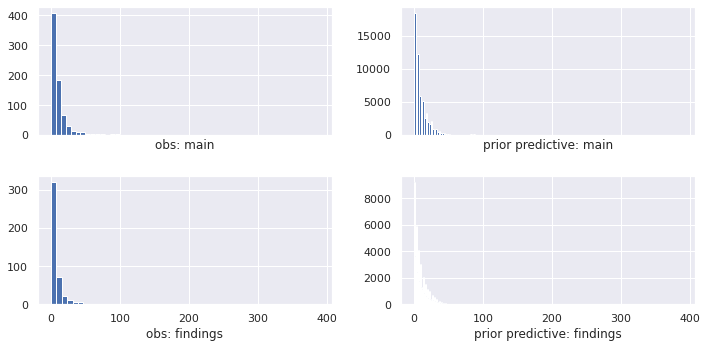

In [9]:
_ = model.plot_predictions(prior_samples)

We can also plot some statistics just to see whether indeed our prior is not excluding plausible observations.

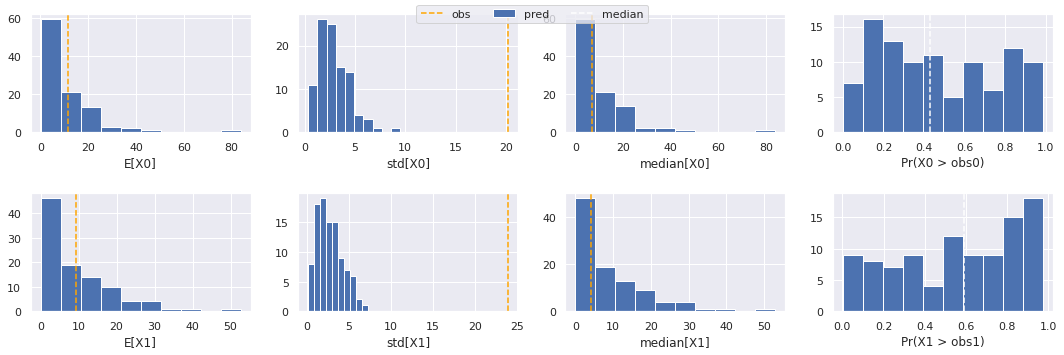

In [10]:
_ = model.plot_checks(prior_samples)

## Posterior

Time to run our sampler. Numpyro is fast!

In [11]:
model.run()

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta[0,0]      0.54      0.02      0.54      0.51      0.57  18605.46      1.00
  beta[0,1]      0.77      0.02      0.77      0.74      0.80  24455.73      1.00
  beta[0,2]      0.73      0.04      0.74      0.67      0.80  29458.91      1.00
  beta[0,3]      0.91      0.05      0.92      0.84      0.99  28759.41      1.00
  beta[1,0]      0.94      0.17      1.00      0.79      1.00  18779.16      1.00
  beta[1,1]      0.94      0.16      1.00      0.80      1.00  19924.97      1.00
  beta[1,2]      0.94      0.17      1.00      0.79      1.00  18745.39      1.00
  beta[1,3]      0.93      0.17      1.00      0.78      1.00  18673.80      1.00
lambda[0,0]      3.01      0.14      3.00      2.78      3.24  21898.05      1.00
lambda[0,1]      8.69      0.34      8.69      8.13      9.23  21251.72      1.00
lambda[0,2]     20.24      1.12     20.19     18.38     22.03  21995.60      1.00
lambda[0,3]    

## Posterior predictive

Before any analysis, let's see whether we can trust this model. It's good to plot samples from the posterior predictive distribution (i.e., sample from the generative story *after* conditioning on observations). These can be thought of as replications.

In [12]:
posterior_samples = model.draw_posterior_predictions()
posterior_samples.shape

(20000, 1198)

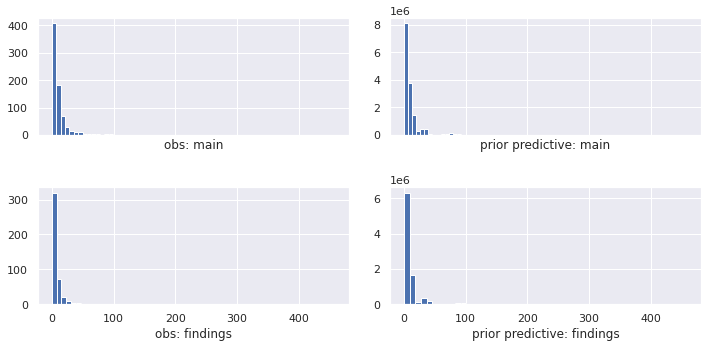

In [13]:
_ = model.plot_predictions(posterior_samples)

And again, we can check whether our posterior predictive generates datasets with statistics that give support to our observed data.

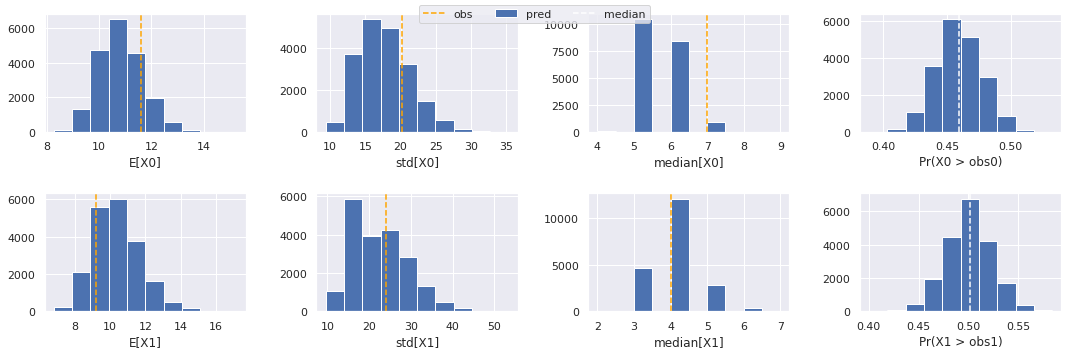

In [14]:
_ = model.plot_checks(posterior_samples)

In [15]:
print(tabulate([(k, v.shape) for k, v in model.posterior_samples.items()], headers=['rv', 'shape']))

rv      shape
------  -------------
beta    (20000, 2, 4)
lambda  (20000, 2, 5)
omega   (20000, 2, 5)
rate    (20000, 2, 5)
rate_z  (20000, 1198)


## Analysis of results


Now we get to interpret the latent parameters of the model, that is, we get to inspect what *patterns* (i.e., what Poisson components) are probable given the data and our assumptions and how the different groups can be explained using these patterns (i.e., mixing coefficients).

Let's start with an overview of the mixing coefficients.

See that some components are barely relevant. Mostly we only need the first 2, perhaps the first 3.

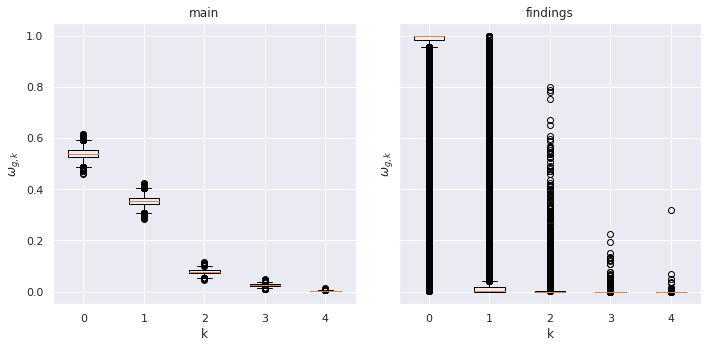

In [16]:
fig, ax = plt.subplots(1, model.G, sharex=True, sharey=True, figsize=(10, 5))
for g in range(model.G):
    _ = ax[g].boxplot(model.posterior_samples['omega'][:,g,:].transpose())
    _ = ax[g].set_xticklabels(np.arange(model.T))
    _ = ax[g].set_title(model.group_names[g])
    _ = ax[g].set_xlabel('k')
    _ = ax[g].set_ylabel(r'$\omega_{g,k}$')
fig.tight_layout(h_pad=2, w_pad=2)

Now, here's the best part.

I'm going to plot $T$ rows, each row concerns a component and will contain
* a histogram of the probable rates for that component, think of it as how many citations papers explained by that component get on average;
* boxplots showing the distribution of that component's weight for the different groups
* and because boxplots can be misleading when distributions are not unimodal and symmetric, I also plot histograms for the coefficients.

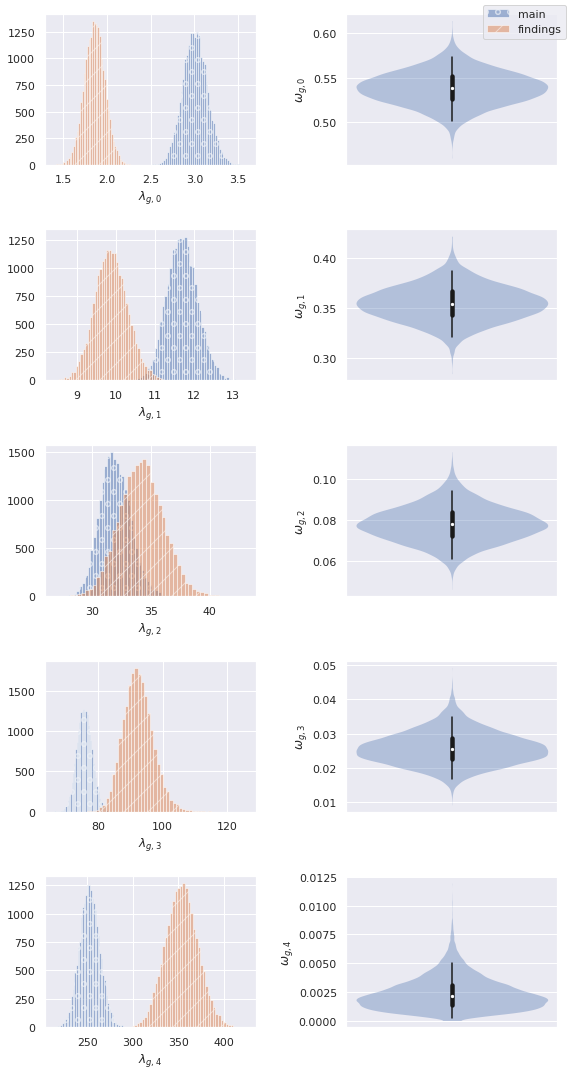

In [17]:
hatches = ['o', '/']
fig, ax = plt.subplots(model.T, 2, figsize=(8, 15))
for t in range(model.T):
    for g in range(model.G):
        _ = ax[t, 0].hist(model.posterior_samples['rate'][:, g, t], alpha=0.5, hatch=hatches[g], bins=50, label=model.group_names[g] if t==0 else None)
        _ = ax[t, 0].set_xlabel(r'$\lambda_{g,%d}$' % t)
    # _ = ax[t, 1].boxplot([model.posterior_samples['omega'][:,g,t].transpose() for g in range(model.G)])
    az.plot_violin({'': model.posterior_samples['omega'][:,0,t].transpose()}, ax=ax[t,1])
    # _ = ax[t, 1].violinplot(
    #     model.posterior_samples['omega'][:,0,t].transpose(),
    #     showmeans=True,
    #     showmedians=True
    # )
    # _ = ax[t, 1].set_xticklabels(model.group_names)
    _ = ax[t, 1].set_ylabel(r'$\omega_{g,%d}$' % t)    
    # for g in range(model.G):
    #     # _ = ax[t, 2].hist(model.posterior_samples['omega'][:,g,t], alpha=0.5, hatch=hatches[g], bins=50, label=model.group_names[g] if t==0 else None)
    #     _ = ax[t, 2].hist(model.posterior_samples['omega'][:,g,t], color='gray', bins=50, label='shared' if t == 0 else None)
    #     _ = ax[t, 2].set_xlabel(r'$\omega_{g,%d}$' % t)
    #     break    
    
fig.legend()
fig.tight_layout(h_pad=2, w_pad=2)